# Explainable Artificial Intelligence

Using SHAP (xAI methodology) we can open black-box models and understand the reasoning of the neural network trained to predict DTC.

We must first define a background used as a reference for the SHAP algorithm. This background will inform the most probable DTC value if we didn't have any information about the features (other conventional logs). If the model predicts any value distinct from the background value, SHAP will obtain the importance of each feature and inform how each contributed to that prediction.

*This notebook was developed in Google Colab in order to use a GPU in a cloud environment and thus acellerate the processing of the XAI algorithm. The visualizations created using the shap library can be seen on the presentation.*

In [ ]:
# In google colab we install specific libraries with the code in this cell
!pip install shap
!pip install tensorflow==2.3

In [ ]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import shap
import tensorflow as tf

In [ ]:
# Load the data (training and test datasets)

DATA_PATH = "../data/processed/"

x_train = np.load(DATA_PATH + "x_train.npy")
x_test = np.load(DATA_PATH + "x_test.npy")
y_train_dtc = np.load(DATA_PATH + "y_train_dtc.npy")
y_test_dtc = np.load(DATA_PATH + "y_test_dtc.npy")

# Create pandas DataFrame using the test features
x_test_df = pd.DataFrame(x_test, columns = ['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN']) 

In [ ]:
# Load the DTC prediction model

dtc_model = tf.keras.models.load_model('dtc_model.h5')

The background will be samples that falls between:

median(DTC) - std(DTC) < DTC < median(DTC) - std(DTC)

In [ ]:
# Obtain the median and standard deviation of the data
# We'll use these values to define a background for SHAP
median = np.median(y_train_dtc)
std = np.std(y_train_dtc)
median, std

In [ ]:
# Defines the background
background = x_train[
  (y_train_dtc > median - std) | (y_train_dtc < median + std)
]

In [ ]:
background.shape # Number of samples in the background

(20245, 7)

In [ ]:
# Instantiates the Explainer object
# We'll also take a random sample of 4000 rows from the background
dtc_deep_explainer = shap.DeepExplainer(dtc_model, shap.sample(background, 4000))

In [ ]:
# Obtain the shap values from the test dataset
shap_values = dtc_deep_explainer.shap_values(x_test)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
# Local explanation
shap.initjs()
shap.force_plot(float(dtc_deep_explainer.expected_value), shap_values[0][0,:], x_test_df.iloc[0,:])

In [ ]:
#Global explanation of 100 samples
random_idx = np.random.choice(shap_values[0].shape[0], 100)

shap.initjs()
shap.force_plot(float(dtc_deep_explainer.expected_value), shap_values[0][random_idx], x_test_df.iloc[random_idx, :])

We can now plot the shap values as xAI Logs along with the DTC prediction. We'll be able to understand how each feature contributed to that prediction at a certain depth.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
y_pred = dtc_model.predict(x_test) # Model predictions

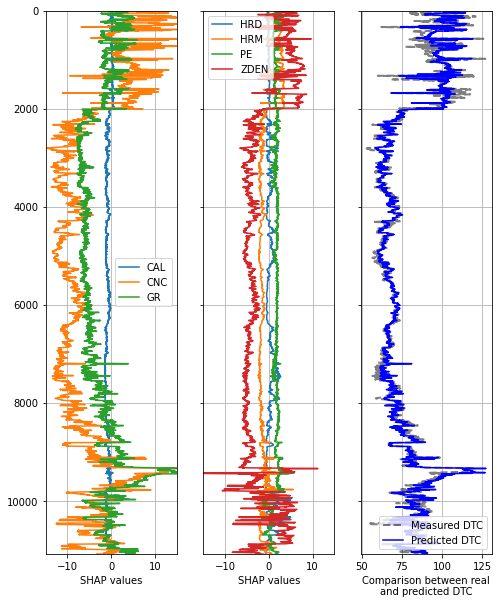

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (8, 10), sharey = True)

y = range(len(y_test_dtc))

labels = x_test_df.columns

for i in range(3):
    ax[0].plot(shap_values[0][:, i], y, label = labels[i])

ax[0].legend()
ax[0].grid()
ax[0].set_xlim(-15, 15)
ax[0].set_xlabel('SHAP values')

for i in range(3, 7):
    ax[1].plot(shap_values[0][:, i], y, label = labels[i])

ax[1].legend()
ax[1].grid()
ax[1].set_xlim(-15, 15)
ax[1].set_xlabel('SHAP values')

ax[2].plot(y_test_dtc[:], y, 'k--', linewidth = 2, alpha = 0.5, label = 'Measured DTC')
ax[2].plot(y_pred, y, 'b-', label = 'Predicted DTC')
ax[2].legend()
ax[2].grid()
ax[2].set_xlabel('Comparison between real\nand predicted DTC')

ax[0].set_ylim(0, y[-1])
ax[0].invert_yaxis();

In [ ]:
# Correlation coefficient between the prediction and real DTC
np.corrcoef(y_pred.reshape(-1), y_test_dtc)

array([[1.        , 0.95628849],
       [0.95628849, 1.        ]])

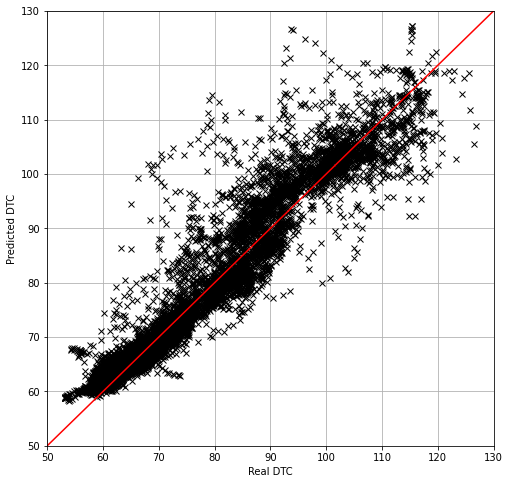

In [ ]:
# This cell creates a crossplot between the predicted and real DTC

fig, ax = plt.subplots(1, 1, figsize = (8, 8))

ax.plot(y_test_dtc, y_pred, 'kx')
ax.plot(range(50, 131), range(50, 131), 'r-')

ax.set_xlim(50, 130)
ax.set_ylim(50, 130)

ax.set_xlabel('Real DTC')
ax.set_ylabel('Predicted DTC')

ax.grid();